In [7]:
import numpy as np
import json

from collections import defaultdict
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

%matplotlib inline

In [18]:
from not_mnist_preprocess import load_not_mnist_data, remove_duplicates

In [92]:
labels, img_train, labels_train, img_test, labels_test = load_not_mnist_data()

Loaded cached arrays


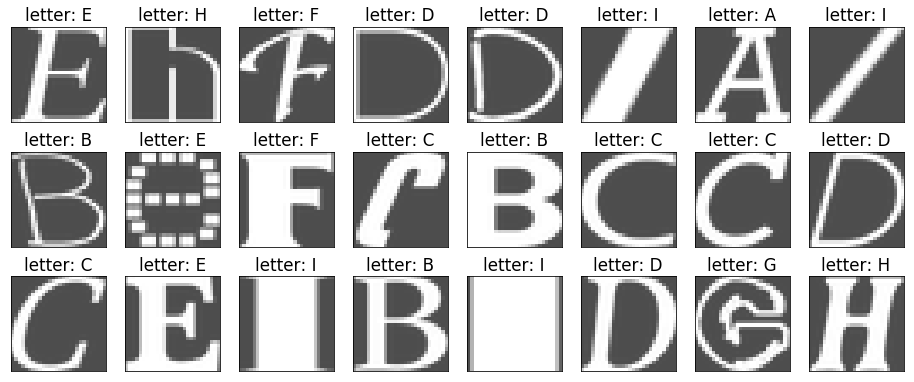

In [93]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 100

rows = 3
cols = 8
fig = plt.figure(figsize=(16, 6.5))
for i in range(1, cols * rows + 1):
    ax = fig.add_subplot(rows, cols, i)
    ax.set_xticks([])
    ax.set_yticks([])
    
    j = np.random.randint(0, labels_test.shape[0] - 1)
    ax.set_title(f"letter: {labels[labels_test[j]]}")
    plt.imshow(img_test[j], cmap='gray', alpha=0.7)

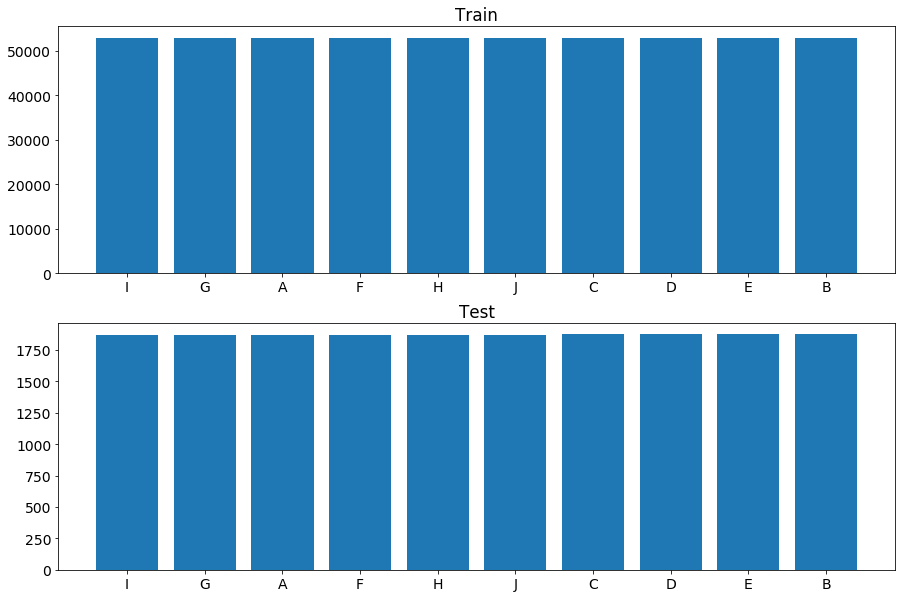

In [94]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 100

def show_balance(title, ax, a, labels):
    counts = defaultdict(int)
    for e in a:
        counts[labels[e]] += 1
        
    ax.bar(counts.keys(), counts.values())
    ax.set_title(title)
    
fig = plt.figure(figsize=(15, 10), )
show_balance("Train", fig.add_subplot(2, 1, 1), labels_train, labels)
show_balance("Test", fig.add_subplot(2, 1, 2), labels_test, labels)

In [95]:
img_train, labels_train = remove_duplicates(img_train, labels_train, img_test)

Removed 12213 duplicated images


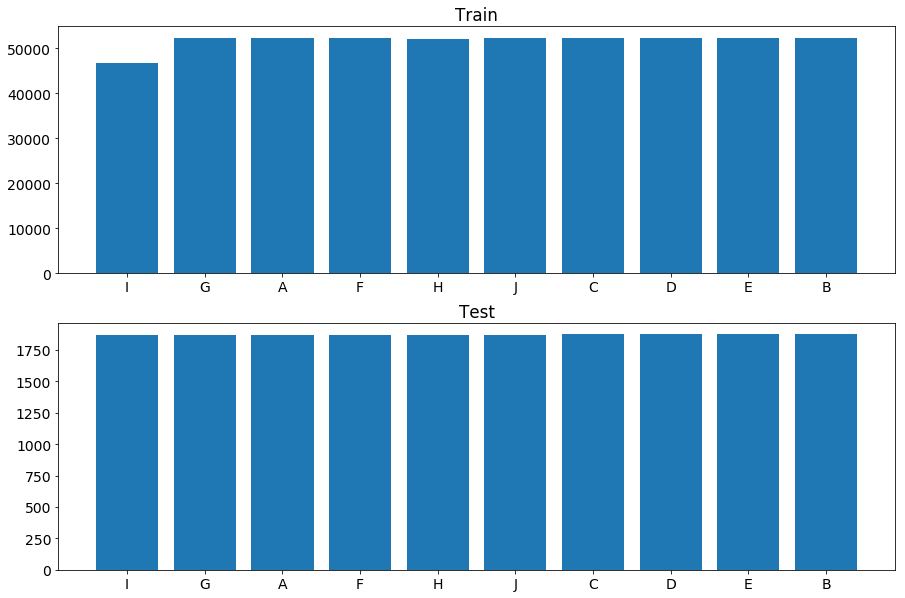

In [96]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 100
    
fig = plt.figure(figsize=(15, 10), )
show_balance("Train", fig.add_subplot(2, 1, 1), labels_train, labels)
show_balance("Test", fig.add_subplot(2, 1, 2), labels_test, labels)

In [ ]:
plt.rcParams['font.size'] = 14
plt.rcParams['font.weight'] = 100

results = {
#     "Simple": fc_nn.results,
#     "With Regularization": fc_nn_r.results,
    "With Adaptive LR": fc_nn_alr.results,
}

fig = plt.figure(figsize=(15, 15))

ax = fig.add_subplot(2, 1, 1)
ax.set(xlabel='Epoch', ylabel='Validation Loss')
ax.set_yticks(np.arange(0, 2, 0.1))

for i, ((model_name, result), marker) in enumerate(zip(results.items(), ['o', 's', '^'])):
    x = [int(n) for n in result.keys()]
    y = [v['val_loss'] for v in result.values()]

    ax.plot(x, y, '-{}'.format(marker), markersize=8, label='Loss', linewidth=2)
    ax.set_xticks(x[::4])
    ax.set_xticklabels(x[::4])

ax.grid()
ax.legend(loc='upper center')

ax = fig.add_subplot(2, 1, 2)
ax.set(xlabel='Epoch', ylabel='Validation Accuracy')
ax.set_yticks(np.arange(0.2, 1.04, 0.025))
ax.axhline(1, ls='--', color='purple', linewidth=2, alpha=0.5)

for i, ((model_name, result), marker) in enumerate(zip(results.items(), ['o', 's', '^'])):
    x = [int(n) for n in result.keys()]
    y = [v['val_acc'] for v in result.values()]

    ax.plot(x, y, '-{}'.format(marker), markersize=8, label=model_name, linewidth=2)
    ax.set_xticks(x[::4])
    ax.set_xticklabels(x[::4])

ax.grid()
ax.legend(loc='lower center')

plt.show()

In [101]:
def plot_results(results):
    n = 2 * len(results.items()) + 3
    
    plt.rcParams['font.size'] = 14
    plt.rcParams['font.weight'] = 100
    fig = plt.figure(figsize=(15, 8 * n))
    
    for i, (model_name, result) in enumerate(results.items()):
        ax = fig.add_subplot(n, 1, 2 * i + 1)
        ax.set_title(f"Loss: {model_name}")
        ax.set(xlabel='Epoch', ylabel='Loss')

        scale = int(np.ceil(len(result['val_loss']) / 50))
        x = [int(n) for n, _ in enumerate(result['val_loss'])][1::scale]
        y1 = [v for v in result['loss']][1::scale]
        y2 = [v for v in result['val_loss']][1::scale]

        ax.plot(x, y1, '-o', markersize=5, label='Train', linewidth=2)
        ax.plot(x, y2, '-s', markersize=5, label='Validation', linewidth=2)
        ax.set_xticks(x[::3])
        ax.set_xticklabels(x[::3])

        ax.grid()
        ax.legend(loc='upper center')

        ax = fig.add_subplot(n, 1, 2 * i + 2)
        ax.set_title(f"Accuracy: {model_name}")
        ax.set(xlabel='Epoch', ylabel='Accuracy')
        ax.axhline(1, ls='--', color='purple', linewidth=2, alpha=0.5)

        x = [int(n) for n, _ in enumerate(result['categorical_accuracy'])][1::scale]
        y1 = [v for v in result['categorical_accuracy']][1::scale]
        y2 = [v for v in result['val_categorical_accuracy']][1::scale]

        ax.plot(x, y1, '-o', markersize=5, label="Train", linewidth=2)
        ax.plot(x, y2, '-s', markersize=5, label="Validation", linewidth=2)
        ax.set_xticks(x[::3])
        ax.set_xticklabels(x[::3])

        ax.grid()
        ax.legend(loc='lower center')
        
        
        
        
    plt.show()

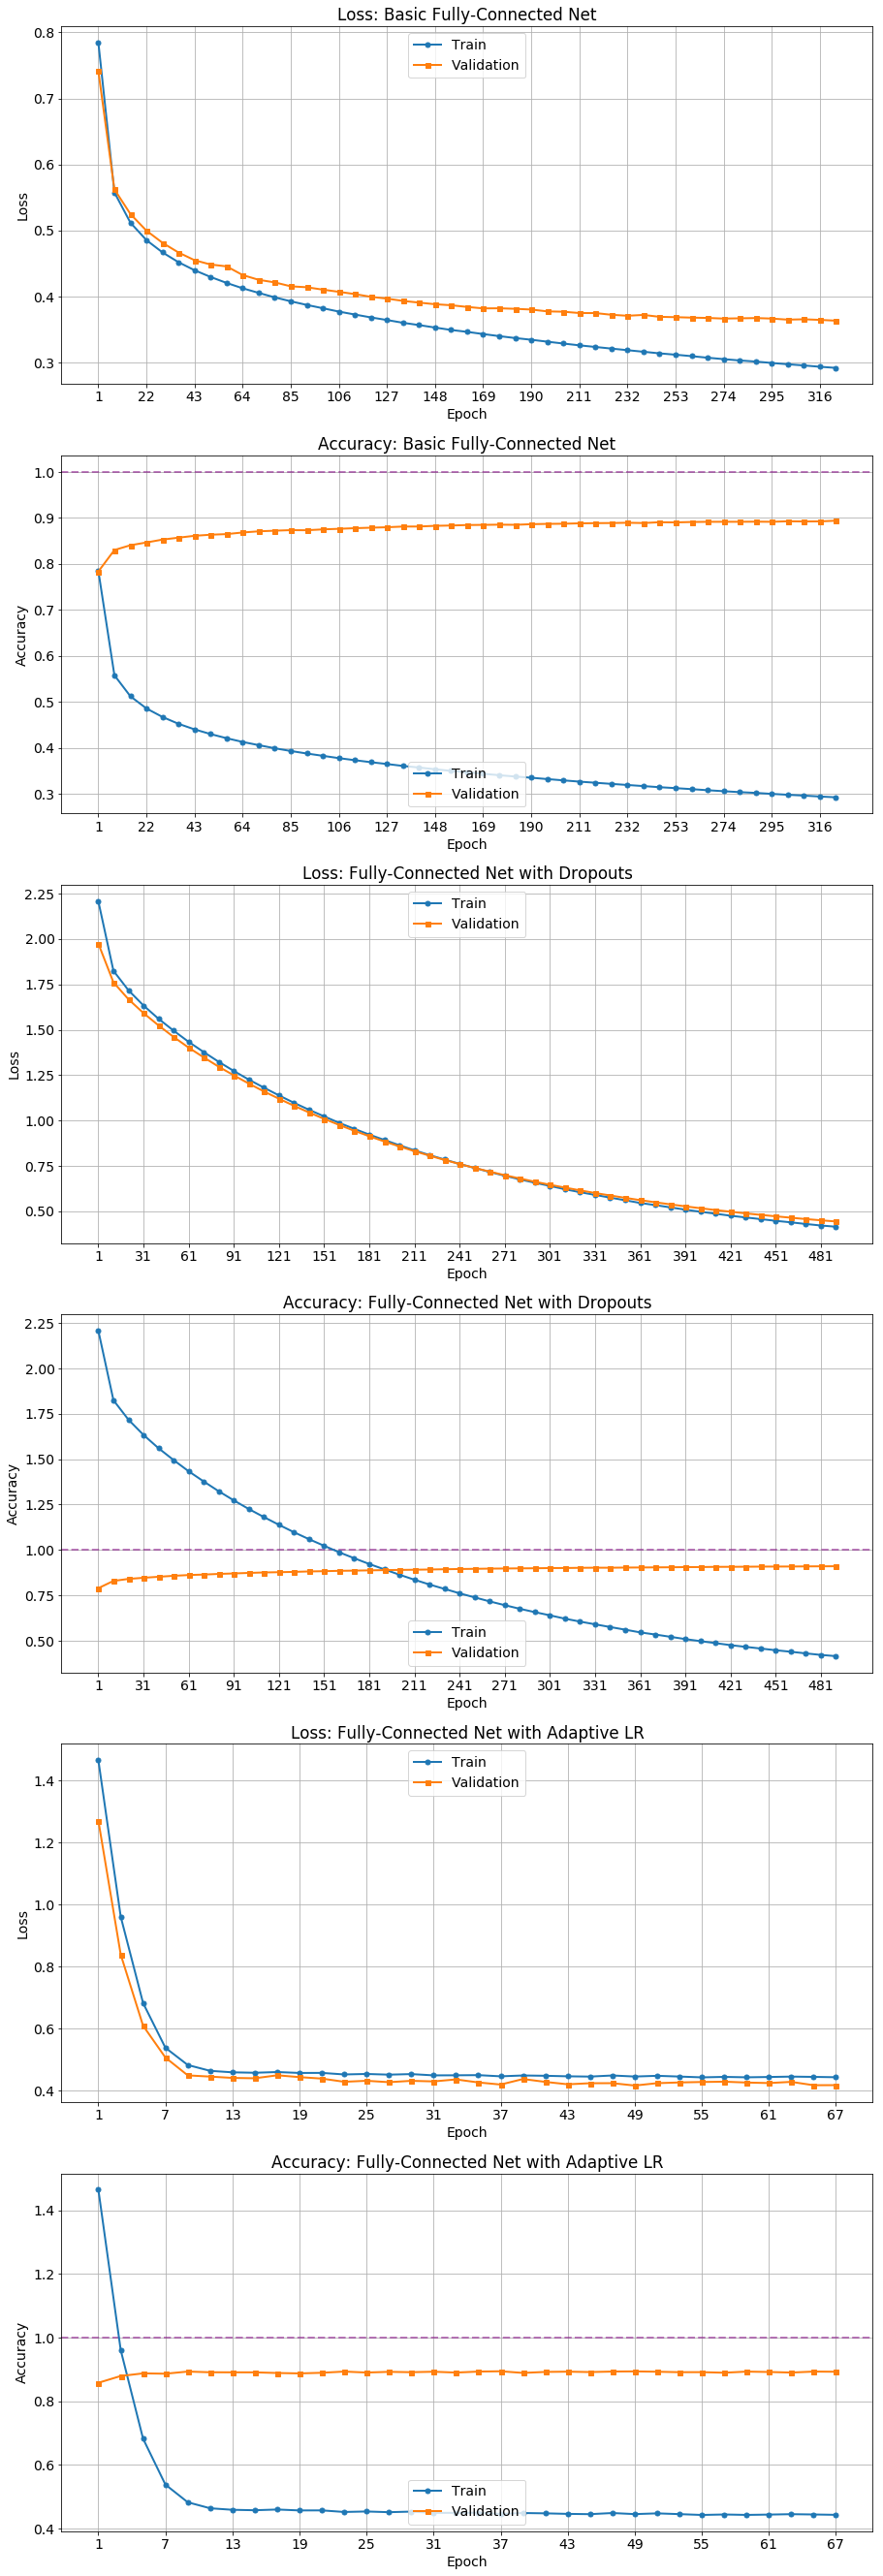

In [102]:
fc_nn_results = {
    "Basic Fully-Connected Net": json.load(open('results/not_mnist_fc_net_basic.json')),
    "Fully-Connected Net with Dropouts": json.load(open('results/not_mnist_fc_net_dropout.json')),
    "Fully-Connected Net with Adaptive LR": json.load(open('results/not_mnist_fc_net_adaptive_lr.json'))
}
plot_results(fc_nn_results)

In [33]:
from svhn_preprocess import load_multiple_digits_data, load_single_digit_data

In [36]:
x_train, y_train, _, _, _, _ = load_single_digit_data()

Loaded cached arrays for train_32x32.mat
Loaded cached arrays for test_32x32.mat


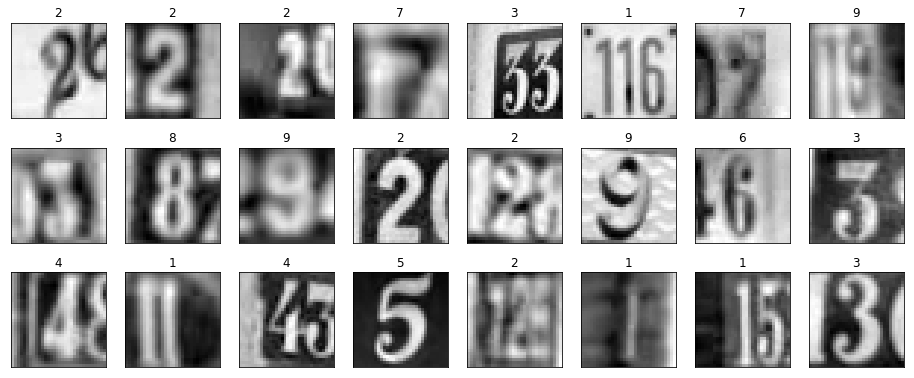

In [43]:
rows = 3
cols = 8
fig = plt.figure(figsize=(16, 6.5))
for i in range(1, cols * rows + 1):
    ax = fig.add_subplot(rows, cols, i)
    ax.set_xticks([])
    ax.set_yticks([])
    
    j = np.random.randint(0, x_train.shape[0] - 1)
    ax.set_title(np.argmax(y_train[j]))
    plt.imshow(x_train[j].reshape((32, 32)), cmap='gray')

In [54]:
x_train, y_train, _, _, _, _ = load_multiple_digits_data()

Loaded cached arrays for data/svhn/train
Loaded cached arrays for data/svhn/test


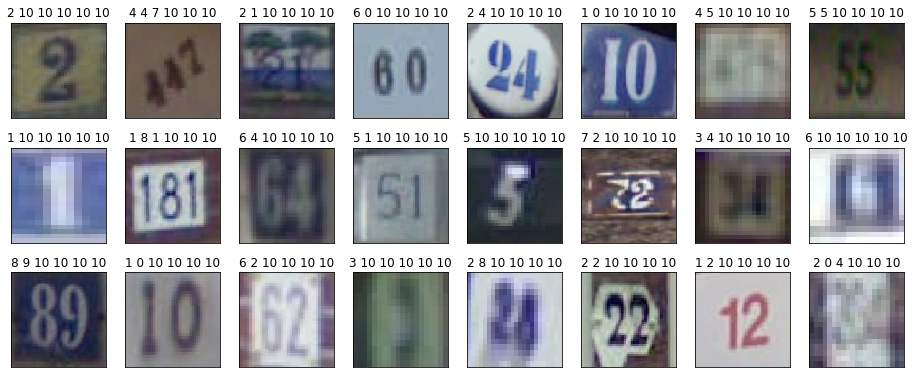

In [57]:
rows = 3
cols = 8
fig = plt.figure(figsize=(16, 6.5))
for i in range(1, cols * rows + 1):
    ax = fig.add_subplot(rows, cols, i)
    ax.set_xticks([])
    ax.set_yticks([])
    
    j = np.random.randint(0, x_train.shape[0] - 1)
    label = ' '.join(str(np.argmax(d)) for d in y_train[j])
    ax.set_title(label)
    plt.imshow(x_train[j])

In [44]:
from svhn_multiple_mobile_net import to_y

In [58]:
from PIL import Image

In [64]:
Image.fromarray(x_train[32]).save('a.jpg')